# GRT Development

This notebook develops some of the key ideas and tools of the new version of GRT

In [2]:
import spiceypy as spy
from matplotlib import pyplot as plt
import pandas as pd
from time import time,strftime
import numpy as np
%matplotlib nbagg
TIME=time()

import tarfile

BDIR=f"./"
DATADIR=f"{BDIR}/data/"
KERDIR=f"{BDIR}/util/kernels/"
FIGDIR=f"{BDIR}/papers/paper1/figures/"

In [3]:
%matplotlib nbagg

## Classes and Routines

### Routines

In [4]:
def elTime(verbose=True):
    global TIME
    t=time()
    dt=t-TIME
    if verbose:print("%.3f s, %.3f min, %g h"%(dt,dt/60.0,dt/3600.0))
    TIME=t

def str2t(date):
    et=spy.str2et(date)
    dt=spy.deltet(et,"ET")
    t=et-dt
    return t
spy.str2t=str2t

class Observer(object):
    """
    lon: longitude, float, radians
    lat: laritude, float, radians
    alt: float, km
    et: TDB in seconds
    """
    _RE=6378.1366 #km, Earth's equatorial radius
    _RP=6356.7519 #km, Earth's polar radius
    _FE=0.0033528131084554717 #Elipticity

    def __init__(self,lon,lat,alt):
        self.lon=lon
        self.lat=lat
        self.alt=alt
        self._positionBody=spy.georec(lon,lat,alt,self._RE,self._FE) 
        self._rho=((self._positionBody[:2]**2).sum())**0.5 #Distance to Earth's axis

        #Minus sign is because local reference frame is: x=North, y=West, z=Up
        #ERROR: This is probably a mistake
        self._velocityLocal=np.array([0,-2*np.pi*self._rho/DAY,0]) 
        self._calcMatrices()
        self._velocityBody=spy.mxv(self._loc2bod,self._velocityLocal)
    
    def _calcMatrices(self):
        uz=spy.surfnm(self._RE,self._RE,self._RP,self._positionBody)
        uy=spy.ucrss(np.array([0,0,1]),uz)
        ux=spy.ucrss(uz,uy)
        self._loc2bod=np.array(np.vstack((ux,uy,uz)).transpose().tolist())
        self._bod2loc=np.linalg.inv(self._loc2bod)
        self._bod2ecl=None
        self._ecl2bod=None
        
    def updateOrientationPosition(self,et):
        self._et=et
        self._bod2ecl=spy.pxform("ITRF93","ECLIPJ2000",et)
        self._ecl2bod=np.linalg.inv(self._bod2ecl)
        self._stateEarth=spy.spkezr("EARTH",et,"ECLIPJ2000","NONE","SSB")[0]
        self._positionEcl=spy.mxv(self._bod2ecl,self._positionBody)
        self._positionEcl=self._positionEcl+self._stateEarth[:3]
        
    def _checkOrientation(self):
        if self._ecl2bod is None:
            raise AssertionError("You must update orientation, eg. observer.updateOrientation(et)")
        
    def ecl2loc(self,eclon,eclat):
        """
        Parameters:
            eclon: Ecliptic longitude, float, radians
            eclat: Ecliptic latitude, float, radians
        Return:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
        """
        self._checkOrientation()
        ecx,ecy,ecz=spy.latrec(1,eclon,eclat)
        x,y,z=spy.mxv(self._bod2loc,spy.mxv(self._ecl2bod,[ecx,ecy,ecz]))
        r,A,h=spy.reclat([x,y,z])
        A=2*np.pi+A if A<0 else A
        return A,h

    def loc2ecl(self,A,h):
        """
        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
        Return:
            eclon: Ecliptic longitude (0,2pi), float, radians
            eclat: Ecliptic latitude (-pi,pi), float, radians
        """
        self._checkOrientation()
        x,y,z=spy.latrec(1,A,h)
        ecx,ecy,ecz=spy.mxv(self._bod2ecl,spy.mxv(self._loc2bod,[x,y,z]))
        r,eclon,eclat=spy.reclat([ecx,ecy,ecz])
        eclon=2*np.pi+eclon if eclon<0 else eclon
        return eclon,eclat

    def vBod2vloc(self,vBod):
        """
        Parameters:
            vBod: Velocity in the body-fixed system, np.array, km/s
        Return:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        """
        vLoc=spy.mxv(self._bod2loc,vBod)
        vloc,A,h=spy.reclat(vLoc)
        A=2*np.pi+A if A<0 else A
        return A,h,vloc
    
    def vloc2vBod(self,A,h,vloc):
        """
        Answer the question: what is the velocity (in the rotating geocentric reference frame) 
        of a particle GOING to A,h at a speed vloc. 
        
        It is VERY important to take into account that if a particle is COMING from A,h, you 
        need to specify its velocity as (A,h,-vloc).

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            vBod: Velocity in the body-fixed system, np.array, km/s
        """
        self._checkOrientation()
        vLoc=spy.latrec(vloc,A,h)
        vBod=spy.mxv(self._loc2bod,vLoc)
        return vBod
    
    def vloc2vRot(self,A,h,vloc):
        """
        Answer the question: what is the velocity (in the non-rotating geocentric reference frame) 
        of a particle GOING from A,h at a speed vloc

        It is VERY important to take into account that if a particle is COMING from A,h, you 
        need to specify its velocity as (A,h,-vloc).

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            vRot: Velocity in the inertial system, body axes, np.array, km/s
        """
        self._checkOrientation()
        vLoc=spy.latrec(vloc,A,h)+self._velocityLocal
        vRot=spy.mxv(self._loc2bod,vLoc)
        return vRot
        
    def vloc2vEcl(self,A,h,vloc):
        """
        Answer the question: what is the velocity (in the heliocentric reference frame) 
        of a particle GOING from A,h to a speed vloc

        It is VERY importante to take into account that if a particle is COMING from A,h, you 
        need to specify its velocity as (A,h,-vloc) or (360-A,h,vloc).

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            vEcl: Velocity in the inertial ecliptic system, np.array, km/s
        """
        vRot=self.vloc2vRot(A,h,vloc)
        vEcl=spy.mxv(self._bod2ecl,vRot)+self._stateEarth[3:]
        return vEcl

    def helioState(self,A,h,vloc):
        """
        Answer the question: what is the heliocentric state of a particle COMING from A,h to a speed vloc

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            geostate: State vector with respect to sun, np.array (6), (km,km,km,km/s,km/s,km/s)
        """
        vEcl=self.vloc2vEcl(A,h,vloc)
        state=np.concatenate((self._positionEcl,vEcl))
        return state

    def geoState(self,A,h,vloc):
        """
        Answer the question: what is the heliocentric state of a particle COMING from A,h to a speed vloc

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            geostate: State vector with respect to geocenter, np.array (6), (km,km,km,km/s,km/s,km/s)
        """
        return self.helioState(A,h,vloc)-self._stateEarth

    
    def vecl2vEcl(self,eclon,eclat,vloc):
        """
        Parameters:
            eclon: Ecliptic longitude (0,2 pi), float, radians
            eclat: Ecliptic latitude (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (0,infty), float, km/s
        Return:
            vEcl: Velocity in the ecliptic system, np.array, km/s
        """
        self._checkOrientation()
        A,h=self.ecl2loc(eclon,eclat)
        vEcl=self.vloc2vEcl(vloc,A,h)
        return vEcl
     
class Angle(object):
    """
    Routines related to angles
    """
    def dms(value):
        """
        Parameters:
            dec: Angle in decimal, float, degree
        Return:
            dms: Angle in dms, tuple/list/array(4), (sign,deg,min,sec)
        """
        sgn=np.sign(value)
        val=np.abs(value)
        deg=np.floor(val)
        rem=(val-deg)*60
        min=np.floor(rem)
        sec=(rem-min)*60
        return (sgn,deg,min,sec)
    def dec(dms):
        """
        Parameters:
            dms: Angle in dms, tuple/list/array(4), (sign,deg,min,sec)
        Return:
            dec: Angle in decimal, float, degree
        """
        return dms[0]*(dms[1]+dms[2]/60.0+dms[3]/3600.0)
    

    
def zappalaDistance(E1,E2):
    """                                                                                                                                                                              
    Zappala (1990), Nervorny & Vokrouhlicky (2006)                                                                                                                                   
    am=(a+at)/2                                                                                                                                                                      
    d2c=1/np.sqrt(am)*(ka*((at-a)/am)**2+ke*(et-e)**2+ki*(sinit-np.sin(i*DEG))**2+kO*(Omega-Ot)**2+kw*(omega-ot)**2)
    Parameters:
        E1: Elements 1, np.array(5), [q(UL),e,i(rad),W(rad),w(rad)]
        E2: Elements 1, np.array(5), [q(UL),e,i(rad),W(rad),w(rad)]
    Return:
        DZ: Zappala distance (when [q]=AU, DZ<0.1 is a good match), float
    """
    #Coefficients
    ka=5./4
    ke=ki=2
    kw=kW=1e-4
    #Elements
    q1,e1,i1,W1,w1=E1[:5]
    q2,e2,i2,W2,w2=E2[:5]
    #Derived elements
    sini1=np.sin(i1)
    sini2=np.sin(i2)
    a1=np.abs(q1/(1-e1))
    a2=np.abs(q2/(1-e2))
    am=(a1+a2)/2
    anm=1/np.sqrt(np.abs(am))
    varpi1=W1+w1
    varpi2=W2+w2
    """
    print("Reference:",E1[:5])
    print("Comparison:",E2[:5])
    print(f"Derived reference: a={a1:g},sini={sini1:g},varpi={varpi1:g}")
    print(f"Derived comparison: a={a2:g},sini={sini2:g},varpi={varpi2:g}")
    print(f"Average: am={am:g},1/sqrt(am)={anm:g}")
    #"""
    #Zappala metric (Zuluaga & Sucerquia, 2018)
    DZ=anm*(ka*(a1-am)**2/am**2+ke*(e1-e2)**2+ki*(sini1-sini2)**2+kW*(W1-W2)**2+kw*(varpi1-varpi2)**2)**0.5

    return DZ

from copy import deepcopy
GLOBAL_OBS=None
def rayOscelt(lon,lat,alt,A,h,vimp,et,rSoI=1e6,simple=True):
    """
    Compute the orbital elements of a particle impacting on lon, lat, alt at time et
    going towards A, h at speed vimp.
    
    Parameters:
        lon: Longitude, float, degrees
        lat: Latitude, float, degrees
        alt: Altitude, float, km
        A: Azimuth, float, degrees
        h: Elevation, float, degrees
        vimp: Impact speed, float (negative), km/s
    """
    #Prepare observer structure
    global GLOBAL_OBS
    if (GLOBAL_OBS is None) or \
            np.isclose([lon,lat,alt],[GLOBAL_OBS.lon*RAD,GLOBAL_OBS.lat*RAD,GLOBAL_OBS.alt],rtol=1e-5).sum()<3:
        #print("New observer")
        obs=Observer(lon*DEG,lat*DEG,alt)
        obs._RP=obs._RE;obs._calcMatrices() #Correction for error in GravRay
        obs.updateOrientationPosition(et)
        GLOBAL_OBS=deepcopy(obs)
    else:
        #print("Old observer")
        obs=GLOBAL_OBS
        if np.isclose(et,GLOBAL_OBS._et,rtol=1e-10)==False:
            #print("New time")
            obs.updateOrientationPosition(et)
            
    #Simple estimation
    if simple:
        heliostate=obs.helioState(A*DEG,h*DEG,vimp)
        E_sim=spy.oscelt(heliostate,et,MUSUN)
    #Geocentric conic:
    geostate=obs.geoState(A*DEG,h*DEG,vimp)
    rt=spy.vnorm(geostate[:3])
    q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(geostate,et,MUEARTH)
    a=q/(1-e)
    n=np.sqrt(MUEARTH/np.abs(a)**3)
    etp=eto-Mo/n
    #SoI:
    fd=np.arccos((q*(1+e)/rSoI-1)/e)
    #See: https://space.stackexchange.com/questions/27602/what-is-hyperbolic-eccentric-anomaly-f
    Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
    Md=e*np.sinh(Hd)-Hd
    deltat=Md/n
    #Heliocentric conic:
    earthpos=spy.spkezr("EARTH",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
    geostatet=spy.conics([q,e,i,Omega,omega,Mo,eto,MUEARTH],etp-deltat)
    soipos=geostatet+earthpos
    E_pcon=spy.oscelt(soipos,etp+deltat,MUSUN)
    if simple:
        return E_sim,E_pcon 
    else:
        return E_pcon 

## Constants

In [5]:
#Numerical
DEG=np.pi/180
RAD=1/DEG

#Phsyical
ELEV=80.0 #km, Reference elevation
AU=1.4959787070000000e8 #km, value assumed in DE430

#Source: DE421
#https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de421_announcement.pdf
MUSUN=132712440040.944000 #km^3/s^2
MUEARTH=398600.436233 #km^3/s^2
MUMOON=4902.800076 #km^3/s^2
MUEARTHMOON=403503.236310 #km^3/s^2

#Time constants
DAY=86400
YEAR=365.24*DAY

#Kernels
kernels=[
    #Time
    "naif0012.tls",
    #Object properties
    "pck00010.tpc",
    #Planetary positions
    #"de421.bsp",
    "de430.bsp",
    #Earth reference system
    #"earth_720101_070426.bpc","earth_070425_370426_predict.bpc","earth_latest_high_prec_20190910.bpc"
    "earth_latest_high_prec_20161205.bpc"
    ]
for kernel in kernels:spy.furnsh(f"{KERDIR}/{kernel}")

### Chelyabinsk

In [7]:
et=spy.str2t("02/15/2013 03:20:34 UTC")
print(et)
Esim,Epcon=rayOscelt(63.5,54.4,80.0,96.0,17.0,-19.0,et)
Epcon[0]/=AU;Epcon[2:5]*=RAD
q,e,i,W,w=Epcon[:5]
print(q,e,i,W,w)

414170434.0
0.7784401174063338 0.6627485942828372 5.072134791174499 326.57268408157256 118.00326540853665


## Data Reading

In [5]:
tar=tarfile.open(f"{BDIR}/../grt-YearTest.tgz", "r:*")
fname=tar.getnames()[50]
data=np.loadtxt(tar.extractfile(fname))
columns=["N","ET","lat","lon","h","Az","vimp","xobs","yobs","zobs","vxobs","vyobs","vzobs","q","e","i","Omega","omega","M","qapex"]
data=pd.DataFrame(data,columns=columns)
data.describe()

,N,ET,lat,lon,h,Az,vimp,xobs,yobs,zobs,vxobs,vyobs,vzobs,q,e,i,Omega,omega,M,qapex
count,5974.000000,5974.0,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5.974000e+03,5.974000e+03,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000
mean,119.981085,4320000.0,-6.889885,10.433316,27.753223,140.701547,19.749785,-1.305854e+08,7.087333e+07,29237.551994,-15.100936,-26.386871,-0.013976,0.730253,0.678064,16.258746,244.268289,181.305184,106.988654,91.079647
std,68.988857,0.0,37.183886,104.274433,18.095077,103.532831,7.127716,3.727003e+03,3.874595e+03,3499.729155,11.967398,11.976818,12.520490,0.266964,0.594659,15.424432,90.495582,107.044110,308.615991,38.688669
min,1.000000,4320000.0,-79.912800,-170.750000,6.603600,1.650200,12.207000,-1.305917e+08,7.086738e+07,23630.154203,-57.597944,-69.054618,-43.036799,0.004617,0.008124,0.007101,9.861022,0.032613,-2660.811059,1.216421
25%,60.000000,4320000.0,-35.081700,-65.969200,12.313000,45.644000,15.054000,-1.305877e+08,7.086986e+07,26579.098588,-23.787571,-35.124090,-9.472926,0.538887,0.325325,6.195231,151.275722,101.232632,54.195378,61.317929
50%,120.000000,4320000.0,-7.025380,22.296400,20.200000,126.730000,18.084000,-1.305861e+08,7.087380e+07,28992.350411,-15.019644,-26.622098,0.131079,0.834616,0.519911,12.468160,330.680227,179.568742,162.136520,91.450623
75%,180.000000,4320000.0,14.262600,89.986500,42.401000,239.630000,22.955000,-1.305823e+08,7.087632e+07,32027.254251,-6.259532,-17.644177,9.414311,0.963237,0.803654,21.599853,331.327782,266.409039,268.962938,118.503866
max,240.000000,4320000.0,70.195900,175.522000,62.009000,340.080000,43.039000,-1.305793e+08,7.087982e+07,35687.726464,28.618088,16.615438,43.101787,1.006849,4.738611,175.063778,358.669588,359.987995,359.992376,178.260480


## Asymptotic orbit determination

## Numerical determination

In this section we read the information about the results of determining the asymptotic orbit using the numerical integration procedure in the original GRT.

## Simple determination

Here we will attempt to determine the orbital elements starting only on the location of the 

In [449]:
iev=100
event=data.iloc[iev]
obs=Observer(event["lon"]*DEG,event["lat"]*DEG,ELEV)
obs._RP=obs._RE;obs._calcMatrices() #Correction for error in GravRay
obs.updateOrientationPosition(event["ET"])
event["lat"],event["lon"],event["Az"],event["h"],event["vimp"],event["ET"],spy.et2utc(event["ET"],"C",0)

(-16.4228, -29.9483, 1.6502, 56.981, 12.207, 4320000.0, '2000 FEB 20 11:58:56')

In [450]:
#Comparison
opt=(event["Az"])*DEG,event["h"]*DEG,-event["vimp"]
#opt=(360-event["Az"])*DEG,-event["h"]*DEG,event["vimp"]
obs._positionEcl,obs.vloc2vEcl(*opt),\
event[["xobs","yobs","zobs"]].values,event[["vxobs","vyobs","vzobs"]].values

(array([-1.30582607e+08,  7.08678075e+07,  3.03545799e+04]),
 array([-21.15994001, -18.55652399,  -7.13746505]),
 array([-1.30582607e+08,  7.08678075e+07,  3.03545799e+04]),
 array([-21.15990113, -18.55669163,  -7.13767917]))

In [451]:
#Numerically determined
q,e,i,Omega,omega,M=event[["q","e","i","Omega","omega","M"]].values
print(f"q={q} AU,e={e},i={i},W={Omega},w={omega}\nM={M},a={q/(1-e)} AU")

q=0.8600572458010401 AU,e=0.1294093814540304,i=7.450907416751878,W=331.6998734666597,w=78.89875965056892
M=72.28317106246105,a=0.9879008887523714 AU


In [453]:
#Simply determined
heliostate=obs.helioState(event["Az"]*DEG,event["h"]*DEG,-event["vimp"])
q,e,i,Omega,omega,M,et,mu,f,a,P=spy.oscltx(heliostate,event["ET"],MUSUN)
print(f"q={q/AU} AU,e={e},i={i*RAD},W={Omega*RAD},w={omega*RAD}\nM={M*RAD},f={f*RAD},a={a/AU} AU,P={P/YEAR} yr")

q=0.6208004537398066 AU,e=0.3397801182292079,i=15.131354585297741,W=331.55439362800547,w=61.37840100362403
M=80.32341393146227,f=118.57675434604417,a=0.9402934853684538 AU,P=0.9118328486813002 yr


## Patched conics determination

Here we will attempt to determine the orbital elements using a patched conics determination

### Geocentric elements

In [1]:
geostate=obs.geoState(event["Az"]*DEG,event["h"]*DEG,-event["vimp"])
rt=spy.vnorm(geostate[:3])
q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(geostate,event["ET"],MUEARTH)
a=q/(1-e)
n=np.sqrt(MUEARTH/np.abs(a)**3)
etp=eto-Mo/n
print(geostate)
print(f"q={q/obs._RE} AU,e={e},i={i*RAD},W={Omega*RAD},w={omega*RAD}\nM={Mo*RAD},\
f={f*RAD},a={a/obs._RE} AU, n={n} rad/s,\nr = {rt} km, tp = {tp} s")

NameError: name 'obs' is not defined

In [578]:
r=1e6
fd=np.arccos((q*(1+e)/r-1)/e)
Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
Md=e*np.sinh(Hd)-Hd
deltat=Md/n
print(f"f={fd*RAD},H={Hd*RAD},M={Md*RAD},deltat={deltat} s")

f=150.6726073138603,H=272.1774367984908,M=3509.317755306966,deltat=185083.1099750669 s


In [579]:
geostatet=spy.conics([q,e,i,Omega,omega,Mo,eto,MUEARTH],etp-deltat)
q,spy.vnorm(geostatet[:3]),geostate

(2178.9637874766177,
 1000000.0000000293,
 array([ 3053.67473812, -5668.3582563 ,   480.00683585,    -6.320487  ,
            7.64918578,    -7.13638064]))

In [581]:
#Patched conics
earthpos=spy.spkezr("EARTH",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
soipos=geostatet+earthpos
q,e,i,Omega,omega,M,et,mu,f,a,P=spy.oscltx(soipos,etp+deltat,MUSUN)
print(f"Patched Conics: q={q/AU} AU,e={e},i={i*RAD},W={Omega*RAD},w={omega*RAD}\nM={M*RAD},f={f*RAD},a={a/AU} AU,P={P/YEAR} yr")
#Numerically determined
q,e,i,Omega,omega,M=event[["q","e","i","Omega","omega","M"]].values
print(f"Numerical: q={q} AU,e={e},i={i},W={Omega},w={omega}\nM={M},a={q/(1-e)} AU")

Patched Conics: q=0.8563731463836756 AU,e=0.12977516363439923,i=7.5579937986248416,W=331.68568171473754,w=78.4364980970789
M=84.41076286489864,f=99.27970560631498,a=0.9840826308293207 AU,P=0.9762643769210295 yr
Numerical: q=0.8600572458010401 AU,e=0.1294093814540304,i=7.450907416751878,W=331.6998734666597,w=78.89875965056892
M=72.28317106246105,a=0.9879008887523714 AU


### Studying speeds

In [392]:
#Zero-observer
#et=spy.str2et("2000 JAN 01 12:00:00 UTC")
et=spy.str2et("2000 MAR 22 12:00:00 UTC")
sim=Observer(0*DEG,0*DEG,0)
sim.updateOrientationPosition(et)

In [393]:
sim._velocityLocal,sim._velocityBody,sim._loc2bod,sim._bod2ecl

(array([ 0.        , -0.46383118,  0.        ]),
 array([ 0.        , -0.46383118,  0.        ]),
 array([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]]),
 array([[ 9.99986620e-01, -5.17301033e-03, -7.88447915e-06],
        [ 4.74931696e-03,  9.17476861e-01,  3.97760799e-01],
        [-2.05038689e-03, -3.97755514e-01,  9.17489154e-01]]))

In [394]:
sim._stateEarth

array([-1.49976941e+08, -6.16003355e+06,  2.93325853e+04,  6.50583742e-01,
       -2.98798520e+01, -2.35420741e-04])

In [420]:
A=(90.0-23.5)
h=0.0
vimp=-10
vdir=A*DEG,h*DEG,vimp
print("Earth heliograme:",sim._stateEarth[3:])
print("In the rotating geoframe:",sim.vloc2vBod(*vdir))
print("In the non-rotating geoframe:",sim.vloc2vRot(*vdir))
print("In the helioframe:",sim.vloc2vEcl(*vdir))

Earth heliograme: [ 6.50583742e-01 -2.98798520e+01 -2.35420741e-04]
In the rotating geoframe: [-0.         -9.17060074 -3.98749069]
In the non-rotating geoframe: [ 0.         -9.63443193 -3.98749069]
In the helioframe: [  0.7004542  -40.30528784   0.17343355]


Here, we have a mistake.  If a particle in the rotating reference frame have a y-component of -9.17 km/s (going towards the west) it is because in the inertial reference frame have a y-componente of -8.8 km/s.  This is because the rotation velocity of the Earth is toward East.  Therefore to the inertial velocity -8.8 km/s you have to add the rotational velocity 0.4 km/s.

In the original GravRay we have a mistake equivalent to have assumed that the Earth was rotating clockwise.

### Observer class

## Test routines

In [407]:
np.isclose([1,2],[1,2])

array([ True,  True])

In [139]:
import unittest
class Test(unittest.TestCase):
    
    #Zero-observer
    et=spy.str2et("2000 JAN 01 12:00:00 UTC")
    observer=Observer(0*DEG,0*DEG,0)
    observer.updateOrientationPosition(et)

    #Chelyabinsk impact
    etchely=spy.str2et("02/15/2013 3:20:34 UTC")
    chely=Observer(61.1*DEG,54.8*DEG,23.3)
    chely.updateOrientationPosition(etchely)
    
    #Arbitrary impact
    etarb=4320000.0 #Feb. 20/2000, 12:00:00 TDB
    arb=Observer(-29.9483*DEG,-16.4228*DEG,80.0)
    arb._RP=arb._RE;arb._calcMatrices() #Error in GravRay
    arb.updateOrientationPosition(etarb)

    def test_earthpos(self):
        self.assertEqual(np.isclose(self.arb._stateEarth,
                                    np.array([-1.30585661e+08,7.08734759e+07,2.98745730e+04,
                                              -1.48394530e+01,-2.62057098e+01,-1.08440413e-03]),
                                    rtol=1e-5).tolist(),
                         [True]*6)
    
    def test_vrot(self):
        vrot=self.observer.vloc2vRot(90*DEG,0*DEG,10.0)
        self.assertAlmostEqual(vrot[0],0,5)
        self.assertAlmostEqual(vrot[1],9.53616882e+00,5)
        self.assertAlmostEqual(vrot[2],0,5)
        
    def test_arb_position(self):
        self.assertTrue(np.isclose(self.arb._positionEcl[0],-1.30582607e+08,rtol=1e-7,atol=0,equal_nan=False))
        self.assertTrue(np.isclose(self.arb._positionEcl[1],7.08678075e+07,rtol=1e-7,atol=0,equal_nan=False))
        self.assertTrue(np.isclose(self.arb._positionEcl[2],3.03545799e+04,rtol=1e-7,atol=0,equal_nan=False))
        
    def test_arb_velocity(self):
        vecl=self.arb.vloc2vEcl(1.6502*DEG,56.981*DEG,-12.207)
        self.assertTrue(np.isclose(vecl[0],-21.15990113,rtol=1e-4,atol=0,equal_nan=False))
        self.assertTrue(np.isclose(vecl[1],-18.55669163,rtol=1e-4,atol=0,equal_nan=False))
        self.assertTrue(np.isclose(vecl[2],-7.13767917,rtol=1e-4,atol=0,equal_nan=False))
    
    def test_et(self):
        self.assertAlmostEqual(self.et,64.2,1)
        
    def test_ellipsoid(self):
        self.assertAlmostEqual(self.observer._RE,6378.1366,4)
        self.assertAlmostEqual(self.observer._RP,6356.7519,4)
        self.assertAlmostEqual(self.observer._FE,0.0033528131084554717,7)
    
    def test_position(self):
        self.assertEqual(self.observer._positionBody[0],self.observer._RE)
        
    def test_velocity_local(self):
        self.assertAlmostEqual(self.observer._velocityLocal[0],0,5)
        self.assertAlmostEqual(self.observer._velocityLocal[1],-0.46383118,5)
        self.assertAlmostEqual(self.observer._velocityLocal[2],0,5)
        
    def test_ecl2loc_sun(self):
        #Position of the Sun
        eclon=Angle.dec((+1,280,22,21.9))
        eclat=Angle.dec((-1,0,0,2.7))
        A,h=self.observer.ecl2loc(eclon*DEG,eclat*DEG)
        self.assertAlmostEqual(A*RAD,178.07231644928592,5)
        self.assertAlmostEqual(h*RAD,66.95277694576103,5)
    
    def test_ecl2loc_Betelgeuse(self):
        #Betelgeuse
        eclon=Angle.dec((+1,88,45,16.6))
        eclat=Angle.dec((-1,16,1,37.2))
        A,h=self.observer.ecl2loc(eclon*DEG,eclat*DEG)
        self.assertAlmostEqual(A*RAD,57.27518638612843,5)
        self.assertAlmostEqual(h*RAD,-76.20677246845091,5)
    
    def test_loc2ecl_sun(self):
        A=Angle.dec((+1,57,16,30.7))
        h=Angle.dec((-1,76,12,24.4))
        eclon,eclat=self.observer.loc2ecl(A*DEG,h*DEG)
        self.assertAlmostEqual(eclon*RAD,88.75461469860417,5)
        self.assertAlmostEqual(eclat*RAD,-16.027004471139914,5)
        
    def test_chely_et(self):
        self.assertAlmostEqual(self.etchely,414170501.185,3)
        
    def test_chely_vbod2vloc(self):
        vBod=np.array([12.8,-13.3,-2.4])
        A,h,vloc=self.chely.vBod2vloc(-vBod)
        self.assertAlmostEqual(A*RAD,99.8961127649985,5)
        self.assertAlmostEqual(h*RAD,15.92414245029081,5)

    def test_chely_vloc2vbod(self):
        vBod=self.chely.vloc2vBod(279.9*DEG,-15.9*DEG,18.6)
        self.assertAlmostEqual(vBod[0],12.8,1)
        self.assertAlmostEqual(vBod[1],-13.3,1)
        self.assertAlmostEqual(vBod[2],-2.4,1)
        
    def test_chely_elements(self):
        et=spy.str2t("02/15/2013 03:20:34 UTC")
        Esim,Epcon=rayOscelt(63.5,54.4,80.0,96.0,17.0,-19.0,et)
        Epcon[0]/=AU;Epcon[2:5]*=RAD
        q,e,i,W,w=Epcon[:5]
        self.assertEqual(np.isclose([q,e,i,W,w],
                                    [0.78,0.66,5.07,326.57,118.00],
                                     atol=1e-1).tolist(),
                         [True]*5)
        
if __name__=='__main__':
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

...............
----------------------------------------------------------------------
Ran 15 tests in 0.038s

OK


## Comparison Procedure

In [604]:
iev=100
event=data.iloc[iev]
#Elements
q_num,e_num,i_num,W_num,w_num,M_num=event[["q","e","i","Omega","omega","M"]].values
q_num*=AU;i_num*=DEG;W_num*=DEG;w_num*=DEG;M_num*=DEG
#Build observer
obs=Observer(event["lon"]*DEG,event["lat"]*DEG,ELEV)
obs._RP=obs._RE;obs._calcMatrices() #Correcçtion for error in GravRay
obs.updateOrientationPosition(event["ET"])
#Simply determined
heliostate=obs.helioState(event["Az"]*DEG,event["h"]*DEG,-event["vimp"])
q_sim,e_sim,i_sim,W_sim,w_sim,M_sim,et,mu=spy.oscelt(heliostate,event["ET"],MUSUN)
#Patched conics
#Geocentric conic:
geostate=obs.geoState(event["Az"]*DEG,event["h"]*DEG,-event["vimp"])
rt=spy.vnorm(geostate[:3])
q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(geostate,event["ET"],MUEARTH)
a=q/(1-e)
n=np.sqrt(MUEARTH/np.abs(a)**3)
etp=eto-Mo/n
#SoI:
r=1e6
fd=np.arccos((q*(1+e)/r-1)/e)
Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
Md=e*np.sinh(Hd)-Hd
deltat=Md/n
#Heliocentric conic:
earthpos=spy.spkezr("EARTH",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
geostatet=spy.conics([q,e,i,Omega,omega,Mo,eto,MUEARTH],etp-deltat)
soipos=geostatet+earthpos
q_pcon,e_pcon,i_pcon,W_pcon,w_pcon,M_pcon,et,mu=spy.oscelt(soipos,etp+deltat,MUSUN)
q_pcon,e_pcon,i_pcon,W_pcon,w_pcon,M_pcon,et,mu

(128111599.22365727,
 0.12977516363439923,
 0.13191187663131676,
 5.789007227644121,
 1.3689751455282937,
 1.4732457361126428,
 4505564.902261457,
 132712440040.944)

In [606]:
q_pcon,e_pcon,i_pcon,W_pcon,w_pcon,M_pcon,et,mu=patchedOscelt(obs,
                                                              event["Az"],event["h"],-event["vimp"],
                                                              event["ET"])
q_pcon,e_pcon,i_pcon,W_pcon,w_pcon,M_pcon,et,mu

(128111599.22365727,
 0.12977516363439923,
 0.13191187663131676,
 5.789007227644121,
 1.3689751455282937,
 1.4732457361126428,
 4505564.902261457,
 132712440040.944)

In [599]:
def patchedOscelt(observer,A,h,vimp,et):
    #Geocentric conic:
    geostate=observer.geoState(A*DEG,h*DEG,vimp)
    rt=spy.vnorm(geostate[:3])
    q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(geostate,et,MUEARTH)
    a=q/(1-e)
    n=np.sqrt(MUEARTH/np.abs(a)**3)
    etp=eto-Mo/n
    #SoI:
    r=1e6
    fd=np.arccos((q*(1+e)/r-1)/e)
    Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
    Md=e*np.sinh(Hd)-Hd
    deltat=Md/n
    #Heliocentric conic:
    earthpos=spy.spkezr("EARTH",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
    geostatet=spy.conics([q,e,i,Omega,omega,Mo,eto,MUEARTH],etp-deltat)
    soipos=geostatet+earthpos
    return spy.oscelt(soipos,etp+deltat,MUSUN)

In [316]:
from copy import deepcopy
GLOBAL_OBS=None
def rayOscelt(lon,lat,alt,A,h,vimp,et,simple=True):
    """
    """
    #Prepare observer structure
    global GLOBAL_OBS
    if (GLOBAL_OBS is None) or \
            np.isclose([lon,lat,alt],[GLOBAL_OBS.lon*RAD,GLOBAL_OBS.lat*RAD,GLOBAL_OBS.alt],rtol=1e-5).sum()<3:
        #print("New observer")
        obs=Observer(lon*DEG,lat*DEG,alt)
        obs._RP=obs._RE;obs._calcMatrices() #Correction for error in GravRay
        obs.updateOrientationPosition(et)
        GLOBAL_OBS=deepcopy(obs)
    else:
        #print("Old observer")
        obs=GLOBAL_OBS
        if np.isclose(et,GLOBAL_OBS._et,rtol=1e-10)==False:
            #print("New time")
            obs.updateOrientationPosition(et)
            
    #Simple estimation
    if simple:
        heliostate=obs.helioState(A*DEG,h*DEG,vimp)
        E_sim=spy.oscelt(heliostate,event["ET"],MUSUN)
    #Geocentric conic:
    geostate=obs.geoState(A*DEG,h*DEG,vimp)
    rt=spy.vnorm(geostate[:3])
    q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(geostate,et,MUEARTH)
    a=q/(1-e)
    n=np.sqrt(MUEARTH/np.abs(a)**3)
    etp=eto-Mo/n
    #SoI:
    r=1e6
    fd=np.arccos((q*(1+e)/r-1)/e)
    #See: https://space.stackexchange.com/questions/27602/what-is-hyperbolic-eccentric-anomaly-f
    Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
    Md=e*np.sinh(Hd)-Hd
    deltat=Md/n
    #Heliocentric conic:
    earthpos=spy.spkezr("EARTH",etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
    geostatet=spy.conics([q,e,i,Omega,omega,Mo,eto,MUEARTH],etp-deltat)
    soipos=geostatet+earthpos
    E_pcon=spy.oscelt(soipos,etp+deltat,MUSUN)
    if simple:
        return E_sim,E_pcon 
    else:
        return E_pcon 

In [164]:
iev=100
event=data.iloc[iev]
E_sim,E_pcon=rayOscelt(event["lon"],event["lat"],80.0,event["Az"],event["h"],-event["vimp"],event["ET"])

In [148]:
%timeit -n 1000 rayOscelt(event["lon"],event["lat"],80.0,event["Az"],event["h"],-event["vimp"],event["ET"])

1000 loops, best of 3: 732 µs per loop


In C++ the numerical determination takes 75-86 msec.  In Python it takes 0.5-0.6 msec (without the simple estimation).  This implies an improvement in a factor of ~200 using even python

## Systematic comparison

In [10]:
def zappalaDistance(E1,E2):
    """                                                                                                                                                                              
    Zappala (1990), Nervorny & Vokrouhlicky (2006)                                                                                                                                   
    am=(a+at)/2                                                                                                                                                                      
    d2c=1/np.sqrt(am)*(ka*((at-a)/am)**2+ke*(et-e)**2+ki*(sinit-np.sin(i*DEG))**2+kO*(Omega-Ot)**2+kw*(omega-ot)**2)
    Parameters:
        E1: [q(UL),e,i(rad),W(rad),w(rad)]
    
    """
    ka=5./4
    ke=ki=2
    kw=kW=1e-4
    #Elements
    q1,e1,i1,W1,w1=E1[:5]
    q2,e2,i2,W2,w2=E2[:5]
    #Derived elements
    sini1=np.sin(i1)
    sini2=np.sin(i2)
    a1=q1/(1-e1)
    a2=q2/(1-e2)
    am=(a1+a2)/2
    anm=1/np.sqrt(np.abs(am))
    varpi1=W1+w1
    varpi2=W2+w2
    """
    print("Reference:",E1[:5])
    print("Comparison:",E2[:5])
    print(f"Derived reference: a={a1:g},sini={sini1:g},varpi={varpi1:g}")
    print(f"Derived comparison: a={a2:g},sini={sini2:g},varpi={varpi2:g}")
    print(f"Average: am={am:g},1/sqrt(am)={anm:g}")
    """
    #Metric (Zuluaga & Sucerquia, 2018)
    DZ=anm*(ka*(a1-am)**2/am**2+ke*(e1-e2)**2+ki*(sini1-sini2)**2+kW*(W1-W2)**2+kw*(varpi1-varpi2)**2)**0.5

    return DZ

In [84]:
tar=tarfile.open(f"{BDIR}/../grt-YearTest.tgz", "r:*")
fname=tar.getnames()[50]
data=np.loadtxt(tar.extractfile(fname))
columns=["N","ET","lat","lon","h","Az","vimp","xobs","yobs","zobs","vxobs","vyobs","vzobs","q","e","i","Omega","omega","M","qapex"]
data=pd.DataFrame(data,columns=columns)
data.describe()

,N,ET,lat,lon,h,Az,vimp,xobs,yobs,zobs,vxobs,vyobs,vzobs,q,e,i,Omega,omega,M,qapex
count,5974.000000,5974.0,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5.974000e+03,5.974000e+03,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000
mean,119.981085,4320000.0,-6.889885,10.433316,27.753223,140.701547,19.749785,-1.305854e+08,7.087333e+07,29237.551994,-15.100936,-26.386871,-0.013976,0.730253,0.678064,16.258746,244.268289,181.305184,106.988654,91.079647
std,68.988857,0.0,37.183886,104.274433,18.095077,103.532831,7.127716,3.727003e+03,3.874595e+03,3499.729155,11.967398,11.976818,12.520490,0.266964,0.594659,15.424432,90.495582,107.044110,308.615991,38.688669
min,1.000000,4320000.0,-79.912800,-170.750000,6.603600,1.650200,12.207000,-1.305917e+08,7.086738e+07,23630.154203,-57.597944,-69.054618,-43.036799,0.004617,0.008124,0.007101,9.861022,0.032613,-2660.811059,1.216421
25%,60.000000,4320000.0,-35.081700,-65.969200,12.313000,45.644000,15.054000,-1.305877e+08,7.086986e+07,26579.098588,-23.787571,-35.124090,-9.472926,0.538887,0.325325,6.195231,151.275722,101.232632,54.195378,61.317929
50%,120.000000,4320000.0,-7.025380,22.296400,20.200000,126.730000,18.084000,-1.305861e+08,7.087380e+07,28992.350411,-15.019644,-26.622098,0.131079,0.834616,0.519911,12.468160,330.680227,179.568742,162.136520,91.450623
75%,180.000000,4320000.0,14.262600,89.986500,42.401000,239.630000,22.955000,-1.305823e+08,7.087632e+07,32027.254251,-6.259532,-17.644177,9.414311,0.963237,0.803654,21.599853,331.327782,266.409039,268.962938,118.503866
max,240.000000,4320000.0,70.195900,175.522000,62.009000,340.080000,43.039000,-1.305793e+08,7.087982e+07,35687.726464,28.618088,16.615438,43.101787,1.006849,4.738611,175.063778,358.669588,359.987995,359.992376,178.260480


In [86]:
from tqdm import tqdm
data["DZpcon"]=0
data["DZsim"]=0
sim_elements=["q_sim","e_sim","i_sim","W_sim","w_sim","M_sim"]
pcon_elements=["q_pcon","e_pcon","i_pcon","W_pcon","w_pcon","M_pcon"]
for i,element in enumerate(sim_elements):
    data[element]=0
    data[pcon_elements[i]]=0
for index in tqdm(data.index):
    event=data.loc[index]
    E_num=event[["q","e","i","Omega","omega","M"]].values
    E_num[2:]*=DEG
    E_sim,E_pcon=rayOscelt(event["lon"],event["lat"],80.0,event["Az"],event["h"],-event["vimp"],event["ET"])
    for E in E_sim,E_pcon:E[0]/=AU;
    data[pcon_elements[i]]=0
    data.loc[index,"DZpcon"]=zappalaDistance(E_num,E_pcon)
    data.loc[index,"DZsim"]=zappalaDistance(E_num,E_sim)
    E_sim[2:]*=RAD
    E_pcon[2:]*=RAD
    for i,element in enumerate(sim_elements):
        data.loc[index,element]=E_sim[i]
        data.loc[index,pcon_elements[i]]=E_pcon[i]
    #print(f"Patched conics: {DZpcon:g}, Simple approximation: {DZsim:g}")

100%|██████████| 5974/5974 [02:12<00:00, 45.08it/s]


In [87]:
data[["DZpcon","DZsim","e","e_sim","e_pcon"]].describe()

,DZpcon,DZsim,e,e_sim,e_pcon
count,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000
mean,0.016930,0.287523,0.678064,0.862319,0.683169
std,0.034537,0.131507,0.594659,0.628655,0.597578
min,0.000856,0.020201,0.008124,0.002053,0.008957
25%,0.010545,0.190716,0.325325,0.487567,0.329974
50%,0.014118,0.273329,0.519911,0.694887,0.524848
75%,0.018372,0.369654,0.803654,1.021418,0.809222
max,2.158798,2.208257,4.738611,4.991815,4.751105


In [90]:
sdata=data.sort_values(by="DZpcon",ascending=False)

In [97]:
highDz=sdata[sdata["DZpcon"]>0.05].index.tolist()

In [88]:
data.sort_values(by="DZpcon",ascending=False)[["DZpcon",
                                               "q","q_pcon","e","e_pcon","i","i_pcon",
                                               "Omega","W_pcon","omega","w_pcon"]].head(100)

,DZpcon,q,q_pcon,e,e_pcon,i,i_pcon,Omega,W_pcon,omega,w_pcon
1474,2.158798,0.016877,0.025713,0.527252,0.951372,57.067709,54.042178,139.847971,151.503868,160.715483,176.399796
5275,0.679097,0.044634,0.053040,0.866663,0.943639,92.181199,90.188444,147.611547,151.510124,188.811122,198.258603
4015,0.600337,0.096738,0.104527,0.674379,0.812383,6.020665,6.019212,149.988782,151.390075,186.879973,185.145701
2107,0.581695,0.087156,0.096889,0.702529,0.822261,3.306270,3.309817,151.064288,151.362422,174.833879,179.694104
2781,0.495592,0.097212,0.106778,0.701729,0.808338,19.827119,19.627998,149.448069,151.488004,181.706937,184.758338
3338,0.469054,0.071980,0.083537,0.773614,0.845498,9.047496,8.916927,149.689107,151.441196,172.093446,177.714938
34,0.454219,0.096432,0.104738,0.714017,0.810415,17.462891,17.570545,149.176380,151.476921,190.587877,183.336679
672,0.266840,0.079356,0.090214,0.806693,0.841194,17.364095,17.053206,149.893103,151.480929,183.365399,188.151272
358,0.233240,0.906751,0.876462,3.792993,3.699038,1.286220,1.392040,143.521795,151.090379,335.515198,328.710485
5921,0.172161,0.311437,0.271939,0.524334,0.570495,15.395040,10.393353,151.427750,151.460622,176.508079,177.719708


In [75]:
sort_data=data.sort_values(by="DZpcon",ascending=False)[["DZpcon",
                                                         "q","q_pcon","e","e_pcon","i","i_pcon",
                                                         "Omega","W_pcon","omega","w_pcon"]]

In [159]:
len(data),(data["DZpcon"]>0.1).sum(),(data["DZsim"]>0.1).sum()

(5974, 16, 5680)

## Optimization of SoI

In [114]:
from tqdm import tqdm
data["DZpcon"]=0
data["DZsim"]=0
sim_elements=["q_sim","e_sim","i_sim","W_sim","w_sim","M_sim"]
pcon_elements=["q_pcon","e_pcon","i_pcon","W_pcon","w_pcon","M_pcon"]
for i,element in enumerate(sim_elements):
    data[element]=0
    data[pcon_elements[i]]=0
for index in tqdm(highDz):
    event=data.loc[index]
    E_num=event[["q","e","i","Omega","omega","M"]].values
    E_num[2:]*=DEG
    E_sim,E_pcon=rayOscelt(event["lon"],event["lat"],80.0,event["Az"],event["h"],-event["vimp"],event["ET"],
                          rSoI=1.5e6)
    for E in E_sim,E_pcon:E[0]/=AU;
    data[pcon_elements[i]]=0
    data.loc[index,"DZpcon"]=zappalaDistance(E_num,E_pcon)
    data.loc[index,"DZsim"]=zappalaDistance(E_num,E_sim)
    E_sim[2:]*=RAD
    E_pcon[2:]*=RAD
    for i,element in enumerate(sim_elements):
        data.loc[index,element]=E_sim[i]
        data.loc[index,pcon_elements[i]]=E_pcon[i]
    #print(f"Patched conics: {DZpcon:g}, Simple approximation: {DZsim:g}")

100%|██████████| 98/98 [00:01<00:00, 73.63it/s]


In [115]:
data.iloc[highDz]["DZpcon"].sum()

11.869582539670185

In [170]:
from scipy.optimize import minimize
def optimizeSoI(x,odata=None,indexes=[],usetqdm=False):
    rSoI=10**x[0]
    odata["DZpcon"]=0
    odata["DZsim"]=0
    sim_elements=["q_sim","e_sim","i_sim","W_sim","w_sim","M_sim"]
    pcon_elements=["q_pcon","e_pcon","i_pcon","W_pcon","w_pcon","M_pcon"]
    for i,element in enumerate(sim_elements):
        odata[element]=0
        odata[pcon_elements[i]]=0
    if usetqdm:iterator=tqdm(indexes)
    else:iterator=indexes
    for index in iterator:
        event=odata.loc[index]
        E_num=event[["q","e","i","Omega","omega","M"]].values
        E_num[2:]*=DEG
        E_sim,E_pcon=rayOscelt(event["lon"],event["lat"],80.0,event["Az"],event["h"],-event["vimp"],event["ET"],
                               rSoI=rSoI)
        for E in E_sim,E_pcon:E[0]/=AU;
        odata[pcon_elements[i]]=0
        odata.loc[index,"DZpcon"]=zappalaDistance(E_num,E_pcon)
        odata.loc[index,"DZsim"]=zappalaDistance(E_num,E_sim)
        E_sim[2:]*=RAD
        E_pcon[2:]*=RAD
        for i,element in enumerate(sim_elements):
            odata.loc[index,element]=E_sim[i]
            odata.loc[index,pcon_elements[i]]=E_pcon[i]
    DZsum=odata.iloc[indexes]["DZpcon"].sum()
    return DZsum

In [171]:
optimizeSoI([6],odata=data,indexes=highDz[:100],usetqdm=True)

100%|██████████| 98/98 [00:01<00:00, 67.76it/s]


11.912070710026983

In [160]:
optimizeSoI([6],indexes=data.index.tolist(),usetqdm=True)

100%|██████████| 5974/5974 [01:15<00:00, 79.50it/s]


-11213.592355826368

In [161]:
solution=minimize(optimizeSoI,6,args=(highDz[:50],False),tol=1e-5)
print(f"Optimal distance: {10**solution.x[0]:g}")
solution

Optimal distance: 2.1229e+07


      fun: -49.47006770659492
 hess_inv: array([[2.09883299e-05]])
      jac: array([3.43322754e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 404
      nit: 6
     njev: 131
   status: 2
  success: False
        x: array([7.32693011])

In [162]:
optimizeSoI([solution.x[0]],indexes=data.index.tolist(),usetqdm=True)

100%|██████████| 5974/5974 [01:18<00:00, 76.16it/s]


-8114.2309260572

In [147]:
0.9431*AU*(MUEARTH/MUSUN)**(2./5)

872034.387531225

In [163]:
len(adata)

365000

## Tests

In [94]:
def zappalaDistance(E1,E2):
    """                                                                                                                                                                              
    Zappala (1990), Nervorny & Vokrouhlicky (2006)                                                                                                                                   
    am=(a+at)/2                                                                                                                                                                      
    d2c=1/np.sqrt(am)*(ka*((at-a)/am)**2+ke*(et-e)**2+ki*(sinit-np.sin(i*DEG))**2+kO*(Omega-Ot)**2+kw*(omega-ot)**2)
    Parameters:
        E1: [q(UL),e,i(rad),W(rad),w(rad)]
    
    """
    ka=5./4
    ke=ki=2
    kw=kW=1e-4
    #Elements
    q1,e1,i1,W1,w1=E1[:5]
    q2,e2,i2,W2,w2=E2[:5]
    #Derived elements
    sini1=np.sin(i1)
    sini2=np.sin(i2)
    a1=np.abs(q1/(1-e1))
    a2=np.abs(q2/(1-e2))
    am=(a1+a2)/2
    anm=1/np.sqrt(np.abs(am))
    varpi1=W1+w1
    varpi2=W2+w2
    """
    print("Reference:",E1[:5])
    print("Comparison:",E2[:5])
    print(f"Derived reference: a={a1:g},sini={sini1:g},varpi={varpi1:g}")
    print(f"Derived comparison: a={a2:g},sini={sini2:g},varpi={varpi2:g}")
    print(f"Average: am={am:g},1/sqrt(am)={anm:g}")
    #"""
    #Metric (Zuluaga & Sucerquia, 2018)
    DZ=anm*(ka*(a1-am)**2/am**2+ke*(e1-e2)**2+ki*(sini1-sini2)**2+kW*(W1-W2)**2+kw*(varpi1-varpi2)**2)**0.5

    return DZ

In [91]:
zappalaDistance(sort_data[["q","e","i","Omega","omega"]].iloc[0].values,
                sort_data[["q_pcon","e_pcon","i_pcon","W_pcon","w_pcon"]].iloc[0].values)

Reference: [  0.98586762   0.99349446   5.97355373 331.55818135 186.43354859]
Comparison: [  0.99026818   1.00577883   5.95345928 331.62496599 186.04676179]
Derived reference: a=151.543,sini=-0.304708,varpi=517.992
Derived comparison: a=171.361,sini=-0.323784,varpi=517.672
Average: am=161.452,1/sqrt(am)=0.0787006


0.005967290586121318

### Test Chelyabinsk

In [146]:
#Zuluaga & Ferrin (2013)
et=spy.str2et("02/15/2013 03:20:34 UTC")
Esim,Epcon=rayOscelt(63.5,54.4,80.0,96.0,17.0,-19.0,et)
Epcon[0]/=AU;Epcon[2:5]*=RAD
q,e,i,W,w=Epcon[:5]
print(q,e,i,W,w)

0.7800912010958441 0.6657384288180141 5.014260229541216 326.57335661766507 118.36851018829839


In [150]:
#CNEOS
et=spy.str2et("02/15/2013 03:20:33 UTC")
Esim,Epcon=rayOscelt(61.1,54.8,23.3,99.9,15.9,-18.6,et)
Epcon[0]/=AU;Epcon[2:5]*=RAD
q,e,i,W,w=Epcon[:5]
print(q,e,i,W,w)

0.7442325002224244 0.589106931814524 4.300367832565317 326.57239205199164 109.645303527889


In [169]:
selcols=["h","Az",
         "DZpcon","DZsim",
         "q","q_pcon","q_sim",
         "e","e_pcon","e_sim",
         "i","i_pcon","i_sim",
         "Omega","W_pcon","W_sim",
         "omega","w_pcon","w_sim"]
np.savetxt(f"{BDIR}/../grt-YearTest/grtcomp.data",data[selcols].values)

In [167]:
data.columns

Index(['N', 'ET', 'lat', 'lon', 'h', 'Az', 'vimp', 'xobs', 'yobs', 'zobs',
       'vxobs', 'vyobs', 'vzobs', 'q', 'e', 'i', 'Omega', 'omega', 'M',
       'qapex', 'DZpcon', 'DZsim', 'q_sim', 'q_pcon', 'e_sim', 'e_pcon',
       'i_sim', 'i_pcon', 'W_sim', 'W_pcon', 'w_sim', 'w_pcon', 'M_sim',
       'M_pcon'],
      dtype='object')

### Save analysis

In [214]:
tar=tarfile.open(f"{BDIR}/../grt-YearTest.tgz", "r:*")

In [221]:
from tqdm import tqdm
import random

#Read data
adata=None
ierr=0
Nsel=1000
elTime(verbose=False)
for ntar in range(len(tar.getnames())):
    print(f"Reading file {ntar}...")
    fname=tar.getnames()[ntar]
    data=np.loadtxt(tar.extractfile(fname))
    columns=["N","ET","lat","lon","h","Az","vimp",
             "xobs","yobs","zobs","vxobs","vyobs","vzobs",
             "q","e","i","Omega","omega","M","qapex"]
    data=pd.DataFrame(data,columns=columns)

    #Initialize extracolumns
    data["DZpcon"]=0
    data["DZsim"]=0
    sim_elements=["q_sim","e_sim","i_sim","W_sim","w_sim","M_sim"]
    pcon_elements=["q_pcon","e_pcon","i_pcon","W_pcon","w_pcon","M_pcon"]
    for i,element in enumerate(sim_elements):
        data[element]=0
        data[pcon_elements[i]]=0
        
    #Compute distances
    #for index in tqdm(data.index):
    idata=pd.DataFrame([],columns=data.columns)
    #for index in tqdm(random.sample(data.index.values.tolist(),k=Nsel)):
    for index in random.sample(data.index.values.tolist(),k=Nsel):
        event=data.loc[index]
        E_num=event[["q","e","i","Omega","omega","M"]].values
        E_num[2:]*=DEG
        E_sim,E_pcon=rayOscelt(event["lon"],event["lat"],80.0,event["Az"],event["h"],-event["vimp"],event["ET"])
        for E in E_sim,E_pcon:E[0]/=AU;
        idata.loc[index]=data.loc[index]
        idata[pcon_elements[i]]=0
        idata.loc[index,"DZpcon"]=zappalaDistance(E_num,E_pcon)
        idata.loc[index,"DZsim"]=zappalaDistance(E_num,E_sim)
        E_sim[2:]*=RAD
        E_pcon[2:]*=RAD
        for i,element in enumerate(sim_elements):
            idata.loc[index,element]=E_sim[i]
            idata.loc[index,pcon_elements[i]]=E_pcon[i]
        #print(f"Patched conics: {DZpcon:g}, Simple approximation: {DZsim:g}")
        #break
    selcols=["ET","lon","lat","h","Az","vimp",
             "DZpcon","DZsim",
             "q","q_pcon","q_sim",
             "e","e_pcon","e_sim",
             "i","i_pcon","i_sim",
             "Omega","W_pcon","W_sim",
             "omega","w_pcon","w_sim"]
    fname=f"grtcomp-{ntar:04d}-ET{np.int(event['ET']):010d}.data"
    print(f"\tSaving {fname}...")
    nlarge=(idata["DZpcon"]>0.1).sum()
    ierr+=nlarge
    ndata=len(idata)
    print(f"\tLarge distances: {nlarge}/{ndata}")
    print(f"\tDZ Statistics: (min,mean,std,max)={idata['DZpcon'].min():g},{idata['DZpcon'].mean():g},{idata['DZpcon'].std():g},{idata['DZpcon'].max():g}")
    np.savetxt(f"{BDIR}/../grt-YearTest/{fname}",idata[selcols].values)
    if adata is None:
          adata=pd.DataFrame([],columns=idata[selcols].columns)
    adata=pd.concat((adata,idata[selcols]))
    del(data,idata)
    #if ntar>-1:break

print(f"Mismatches: {ierr}/{(ntar+1)*Nsel} = {ierr/((ntar+1.0)*Nsel)*100:g}%")
elTime(verbose=True)

Reading file 0...





  7%|▋         | 69/1000 [00:21<00:24, 38.51it/s]

	Saving grtcomp-0000-ET0000000000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000149956,0.0100514,0.011632,0.139508
Reading file 1...
	Saving grtcomp-0001-ET0000086400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00027398,0.0103604,0.0148754,0.221754
Reading file 2...
	Saving grtcomp-0002-ET0000172800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000265379,0.01064,0.0175419,0.277585
Reading file 3...
	Saving grtcomp-0003-ET0000259200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000339012,0.0103448,0.0172448,0.395048
Reading file 4...
	Saving grtcomp-0004-ET0000345600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000106205,0.010045,0.0184701,0.405791
Reading file 5...
	Saving grtcomp-0005-ET0000432000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=6.99244e-05,0.0108456,0.018822,0.391875
Reading file 6...
	Saving grtcomp-0006-ET0000518400.data..

	Saving grtcomp-0051-ET0004406400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00135158,0.0172169,0.0248681,0.600156
Reading file 52...
	Saving grtcomp-0052-ET0004492800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000599014,0.0170143,0.0180899,0.459278
Reading file 53...
	Saving grtcomp-0053-ET0004579200.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00119496,0.0171674,0.019511,0.451845
Reading file 54...
	Saving grtcomp-0054-ET0004665600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000816679,0.0162553,0.0105883,0.122953
Reading file 55...
	Saving grtcomp-0055-ET0004752000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000856877,0.0166347,0.0128705,0.187095
Reading file 56...
	Saving grtcomp-0056-ET0004838400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000909133,0.018623,0.0331886,0.792012
Reading file 57...
	Saving grtcomp-0057-ET000492480

	Saving grtcomp-0102-ET0008812800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000665938,0.0197545,0.0137947,0.202108
Reading file 103...
	Saving grtcomp-0103-ET0008899200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000666213,0.0225912,0.0596585,1.76052
Reading file 104...
	Saving grtcomp-0104-ET0008985600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000608713,0.0203866,0.014682,0.263313
Reading file 105...
	Saving grtcomp-0105-ET0009072000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000726174,0.019977,0.013014,0.145509
Reading file 106...
	Saving grtcomp-0106-ET0009158400.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000755314,0.0204653,0.0146889,0.172997
Reading file 107...
	Saving grtcomp-0107-ET0009244800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000819613,0.0201121,0.0136407,0.165723
Reading file 108...
	Saving grtcomp-0108-ET000

	Saving grtcomp-0153-ET0013219200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00160296,0.0170078,0.0144159,0.31207
Reading file 154...
	Saving grtcomp-0154-ET0013305600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00197164,0.0181668,0.0168259,0.333138
Reading file 155...
	Saving grtcomp-0155-ET0013392000.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00199188,0.0164432,0.00979114,0.101954
Reading file 156...
	Saving grtcomp-0156-ET0013478400.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.00180843,0.0169876,0.0136723,0.243336
Reading file 157...
	Saving grtcomp-0157-ET0013564800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00166651,0.016435,0.0124783,0.202546
Reading file 158...
	Saving grtcomp-0158-ET0013651200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.0017619,0.0172131,0.0159917,0.333318
Reading file 159...
	Saving grtcomp-0159-ET0013737

	Saving grtcomp-0204-ET0017625600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.00107569,0.00972323,0.010372,0.137156
Reading file 205...
	Saving grtcomp-0205-ET0017712000.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000281659,0.0105001,0.0207421,0.526734
Reading file 206...
	Saving grtcomp-0206-ET0017798400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000832033,0.0116548,0.0353732,0.813055
Reading file 207...
	Saving grtcomp-0207-ET0017884800.data...
	Large distances: 2/1000
	DZ Statistics: (min,mean,std,max)=0.000627959,0.0102933,0.0210262,0.570891
Reading file 208...
	Saving grtcomp-0208-ET0017971200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000708781,0.0108742,0.0265929,0.54967
Reading file 209...
	Saving grtcomp-0209-ET0018057600.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000512703,0.0106739,0.0240809,0.591631
Reading file 210...
	Saving grtcomp-0210-ET0

	Saving grtcomp-0255-ET0022032000.data...
	Large distances: 0/1000
	DZ Statistics: (min,mean,std,max)=0.0011643,0.0136006,0.00990748,0.0784185
Reading file 256...
	Saving grtcomp-0256-ET0022118400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00135472,0.0148897,0.0199982,0.494209
Reading file 257...
	Saving grtcomp-0257-ET0022204800.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00146721,0.0151655,0.0180821,0.402458
Reading file 258...
	Saving grtcomp-0258-ET0022291200.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00165651,0.0149111,0.0129971,0.138595
Reading file 259...
	Saving grtcomp-0259-ET0022377600.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000889537,0.0151915,0.0188898,0.410439
Reading file 260...
	Saving grtcomp-0260-ET0022464000.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00106901,0.0156258,0.0206534,0.495551
Reading file 261...
	Saving grtcomp-0261-ET002

Reading file 306...
	Saving grtcomp-0306-ET0026438400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.00017999,0.0172063,0.0169086,0.329645
Reading file 307...
	Saving grtcomp-0307-ET0026524800.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000558277,0.0170371,0.0146564,0.327164
Reading file 308...
	Saving grtcomp-0308-ET0026611200.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000334172,0.0164601,0.010656,0.100778
Reading file 309...
	Saving grtcomp-0309-ET0026697600.data...
	Large distances: 1/1000
	DZ Statistics: (min,mean,std,max)=0.000418232,0.0167759,0.0117696,0.168885
Reading file 310...
	Saving grtcomp-0310-ET0026784000.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000478263,0.0176848,0.021897,0.47941
Reading file 311...
	Saving grtcomp-0311-ET0026870400.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.000357397,0.0182839,0.0252635,0.570668
Reading file 312...
	Savin

	Saving grtcomp-0357-ET0030844800.data...
	Large distances: 5/1000
	DZ Statistics: (min,mean,std,max)=0.00133284,0.0142678,0.0169203,0.378889
Reading file 358...
	Saving grtcomp-0358-ET0030931200.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.00109417,0.0138853,0.0197362,0.471115
Reading file 359...
	Saving grtcomp-0359-ET0031017600.data...
	Large distances: 4/1000
	DZ Statistics: (min,mean,std,max)=0.000865997,0.0138217,0.0176718,0.334828
Reading file 360...
	Saving grtcomp-0360-ET0031104000.data...
	Large distances: 9/1000
	DZ Statistics: (min,mean,std,max)=0.000778092,0.0146656,0.0242717,0.549661
Reading file 361...
	Saving grtcomp-0361-ET0031190400.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000892045,0.0133218,0.0221649,0.559111
Reading file 362...
	Saving grtcomp-0362-ET0031276800.data...
	Large distances: 3/1000
	DZ Statistics: (min,mean,std,max)=0.000524679,0.0126267,0.0139008,0.304955
Reading file 363...
	Saving grtcomp-0363-ET0

In [222]:
np.savetxt(f"{BDIR}/../grt-YearTest/grtcomp.data",adata.values)

In [12]:
adata_raw=np.loadtxt(f"{BDIR}/../grt-YearTest/grtcomp.data")
selcols=["ET","lon","lat","h","Az","vimp",
         "DZpcon","DZsim",
         "q","q_pcon","q_sim",
         "e","e_pcon","e_sim",
         "i","i_pcon","i_sim",
         "Omega","W_pcon","W_sim",
         "omega","w_pcon","w_sim"]
adata=pd.DataFrame(adata_raw,columns=selcols)

In [14]:
def medHistogram(data,**args):
    h,x=np.histogram(data,**args)
    xm=(x[1:]+x[:-1])/2
    return h,xm

In [25]:
## Moon stats
stack_moon=np.loadtxt(f"{BDIR}/../grt-YearTestMoon/grtstat.data")
xp_moon,hp_moon,xpg_moon,hpg_moon,xs_moon,hs_moon=[stack_moon[:,i] for i in range(6)]

<IPython.core.display.Javascript object>


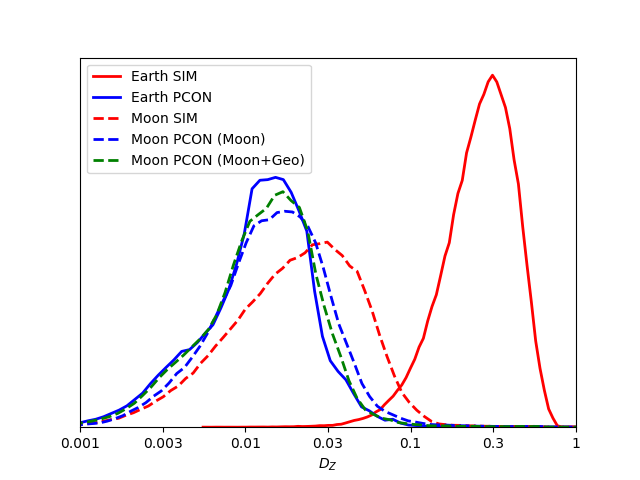

In [53]:
fig=plt.figure()
ax=fig.gca()

hp_earth,xp_earth=medHistogram(np.log10(adata["DZpcon"].values),bins=100,density=True)
hs_earth,xs_earth=medHistogram(np.log10(adata["DZsim"].values),bins=100,density=True)

common=dict(lw=2)
ax.plot(xs_earth,hs_earth,'r-',label="Earth SIM",**common)
ax.plot(xp_earth,hp_earth,'b-',label="Earth PCON",**common)

ax.plot(xs_moon,hs_moon,'r--',label="Moon SIM",**common)
ax.plot(xp_moon,hp_moon,'b--',label="Moon PCON (Moon)",**common)
ax.plot(xpg_moon,hpg_moon,'g--',label="Moon PCON (Moon+Geo)",**common)

ax.set_xlabel(r"$D_Z$")

xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()

ax.set_xlim((-3,0))
ax.set_ylim((0,ymax))

xts=ax.get_xticks()
xtl=[]
for xt in xts:
    xtl+=[f"{10**xt:.1g}"]
ax.set_xticklabels(xtl)
ax.set_yticks([])

ax.legend(loc='upper left')

fig.savefig(f"{FIGDIR}/fig-compare_NUM_SIM_PCON.png")

In [82]:
comparison=["DZpcon","q","q_pcon","e","e_pcon","i","i_pcon","Omega","W_pcon","omega","w_pcon"]
adata.sort_values(by="DZpcon",ascending=False)[comparison].head(50)

,DZpcon,q,q_pcon,e,e_pcon,i,i_pcon,Omega,W_pcon,omega,w_pcon
4093,1.586169,0.020495,0.022495,0.745823,0.957765,71.708171,66.017167,98.909082,78.660697,345.437834,357.457713
1474,1.570505,0.029980,0.036841,0.668394,0.930426,58.703667,59.169570,131.458720,141.445578,193.248382,176.032390
4096,1.520115,0.021420,0.023199,0.758908,0.956402,19.803366,17.684755,113.183395,95.808664,320.316126,357.473636
1726,1.337384,0.037475,0.040510,0.697630,0.923173,27.576285,26.060204,95.937518,106.920616,191.303908,175.842912
4094,1.306058,0.021055,0.021787,1.166800,0.959024,12.014117,11.811102,117.351642,99.631428,326.209887,357.485105
1472,1.222047,0.027963,0.035526,0.788113,0.932886,56.929579,58.741489,132.926900,142.453954,196.125174,176.068554
3994,1.074713,0.034989,0.034274,1.185732,0.940129,8.952256,9.551818,291.034417,276.648878,169.180941,186.177707
3992,1.048784,0.037601,0.035984,1.189980,0.937064,14.529080,15.453302,295.028854,282.387205,172.579145,186.223245
3279,1.030984,0.030258,0.020439,1.162073,0.964330,16.354519,18.397306,239.756329,248.778497,1.455958,5.986427
3992,1.024388,0.036690,0.035647,1.181915,0.937663,13.792276,14.521588,294.748980,281.432531,170.059420,186.208925


In [345]:
RSOI=0.9431*AU*(MUEARTH/MUSUN)**(2./5)
RHILL=AU*(MUEARTH/(3*MUSUN))**(1./3)
RSOI,RHILL

(872034.387531225, 1496558.5265331788)

### SoI optimization

In [332]:
from scipy.optimize import minimize
def optimizeSoI(x,odata=None,indexes=[]):
    rSoI=10**x[0]
    DZsum=0
    for index in indexes:
        event=odata.loc[index]
        E_num=event[["q","e","i","Omega","omega"]].values
        E_num[2:]*=DEG
        E_pcon=rayOscelt(event["lon"],event["lat"],80.0,event["Az"],event["h"],-event["vimp"],event["ET"],
                         rSoI=rSoI,simple=False)
        E_pcon[0]/=AU;
        odata.loc[index,"DZpcon"]=zappalaDistance(E_num,E_pcon)
        DZsum+=odata.loc[index,"DZpcon"]
    return DZsum

In [301]:
sdata=adata.sort_values(by="DZpcon",ascending=False)
sdata.reset_index(inplace=True)
sdata["DZpcon"]=0
ahighDz=sdata[sdata["DZpcon"]>0.05].index.tolist()
len(ahighDz)

6633

In [347]:
elTime(verbose=False)
Dzsum=optimizeSoI([np.log10(2*RHILL)],odata=sdata,indexes=ahighDz[:])
elTime()
Dzsum

37.484 s, 0.625 min, 0.0104122 h


614.2332622090476

In [267]:
fname=tar.getnames()[50]
edata=np.loadtxt(tar.extractfile(fname))
columns=["N","ET","lat","lon","h","Az","vimp","xobs","yobs","zobs","vxobs","vyobs","vzobs","q","e","i","Omega","omega","M","qapex"]
edata=pd.DataFrame(edata,columns=columns)

In [280]:
from tqdm import tqdm
edata["DZpcon"]=0
edata["DZsim"]=0
sim_elements=["q_sim","e_sim","i_sim","W_sim","w_sim","M_sim"]
pcon_elements=["q_pcon","e_pcon","i_pcon","W_pcon","w_pcon","M_pcon"]
for i,element in enumerate(sim_elements):
    edata[element]=0
    edata[pcon_elements[i]]=0
#for index in tqdm(edata.index):
#for index in edata.index:
for index in highDz:
    event=edata.loc[index]
    E_num=event[["q","e","i","Omega","omega","M"]].values
    E_num[2:]*=DEG
    E_sim,E_pcon=rayOscelt(event["lon"],event["lat"],80.0,event["Az"],event["h"],-event["vimp"],event["ET"],
                          rSoI=1.5e6)
    for E in E_sim,E_pcon:E[0]/=AU;
    edata[pcon_elements[i]]=0
    edata.loc[index,"DZpcon"]=zappalaDistance(E_num,E_pcon)
    edata.loc[index,"DZsim"]=zappalaDistance(E_num,E_sim)
    E_sim[2:]*=RAD
    E_pcon[2:]*=RAD
    for i,element in enumerate(sim_elements):
        edata.loc[index,element]=E_sim[i]
        edata.loc[index,pcon_elements[i]]=E_pcon[i]
    #print(f"Patched conics: {DZpcon:g}, Simple approximation: {DZsim:g}")

In [299]:
sedata=edata.sort_values(by="DZpcon",ascending=False)
highDz=sedata[sedata["DZpcon"]>0.05].index.tolist()
len(highDz)

90

In [300]:
optimizeSoI([6],idata=sedata,indexes=highDz,usetqdm=False)

11.501828984343735

In [305]:
solution=minimize(optimizeSoI,6,args=(sedata,highDz,False),tol=1e-5)
print(f"Optimal distance: {10**solution.x[0]:g}")
solution

Optimal distance: 1.65163e+07


      fun: 11.14129672133983
 hess_inv: array([[0.06465352]])
      jac: array([0.05952728])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 259
      nit: 5
     njev: 84
   status: 2
  success: False
        x: array([7.21791335])

In [338]:
from datetime import datetime
now=datetime.now

In [342]:
now()

datetime.datetime(2019, 6, 24, 20, 37, 58, 751095)

In [343]:
elTime(verbose=False)
solution=minimize(optimizeSoI,[6],args=(sdata,ahighDz[:]),tol=1e-5)
print(f"Optimal distance: {10**solution.x[0]:g}")
elTime(verbose=True)
solution

Optimal distance: 3.42377e+06
8335.400 s, 138.923 min, 2.31539 h


      fun: 614.0149519551808
 hess_inv: array([[0.03032582]])
      jac: array([4.80532074])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 216
      nit: 2
     njev: 70
   status: 2
  success: False
        x: array([6.53450508])

In [352]:
from tqdm import tqdm
elTime(verbose=False)
edata["DZpcon"]=0
edata["DZsim"]=0
sim_elements=["q_sim","e_sim","i_sim","W_sim","w_sim","M_sim"]
pcon_elements=["q_pcon","e_pcon","i_pcon","W_pcon","w_pcon","M_pcon"]
for i,element in enumerate(sim_elements):
    edata[element]=0
    edata[pcon_elements[i]]=0
#for index in tqdm(edata.index):
#for index in edata.index:
for index in edata.index:
    event=edata.loc[index]
    E_num=event[["q","e","i","Omega","omega","M"]].values
    E_num[2:]*=DEG
    E_sim,E_pcon=rayOscelt(event["lon"],event["lat"],80.0,event["Az"],event["h"],-event["vimp"],event["ET"],
                           rSoI=2*RHILL)
    for E in E_sim,E_pcon:E[0]/=AU;
    edata[pcon_elements[i]]=0
    edata.loc[index,"DZpcon"]=zappalaDistance(E_num,E_pcon)
    edata.loc[index,"DZsim"]=zappalaDistance(E_num,E_sim)
    E_sim[2:]*=RAD
    E_pcon[2:]*=RAD
    for i,element in enumerate(sim_elements):
        edata.loc[index,element]=E_sim[i]
        edata.loc[index,pcon_elements[i]]=E_pcon[i]
    #print(f"Patched conics: {DZpcon:g}, Simple approximation: {DZsim:g}")
elTime()

90.987 s, 1.516 min, 0.0252742 h


In [351]:
edata[comparison].sort_values(by="DZpcon",ascending=False)

,DZpcon,q,q_pcon,e,e_pcon,i,i_pcon,Omega,W_pcon,omega,w_pcon
1474,2.158798,0.016877,0.025713,0.527252,0.951372,57.067709,54.042178,139.847971,151.503868,160.715483,176.399796
5275,0.679097,0.044634,0.053040,0.866663,0.943639,92.181199,90.188444,147.611547,151.510124,188.811122,198.258603
4015,0.600337,0.096738,0.104527,0.674379,0.812383,6.020665,6.019212,149.988782,151.390075,186.879973,185.145701
2107,0.581695,0.087156,0.096889,0.702529,0.822261,3.306270,3.309817,151.064288,151.362422,174.833879,179.694104
2781,0.495592,0.097212,0.106778,0.701729,0.808338,19.827119,19.627998,149.448069,151.488004,181.706937,184.758338
3338,0.469054,0.071980,0.083537,0.773614,0.845498,9.047496,8.916927,149.689107,151.441196,172.093446,177.714938
34,0.454219,0.096432,0.104738,0.714017,0.810415,17.462891,17.570545,149.176380,151.476921,190.587877,183.336679
672,0.266840,0.079356,0.090214,0.806693,0.841194,17.364095,17.053206,149.893103,151.480929,183.365399,188.151272
358,0.233240,0.906751,0.876462,3.792993,3.699038,1.286220,1.392040,143.521795,151.090379,335.515198,328.710485
5921,0.172161,0.311437,0.271939,0.524334,0.570495,15.395040,10.393353,151.427750,151.460622,176.508079,177.719708


In [353]:
edata[comparison].sort_values(by="DZpcon",ascending=False)

,DZpcon,q,q_pcon,e,e_pcon,i,i_pcon,Omega,W_pcon,omega,w_pcon
1474,2.158863,0.016877,0.025712,0.527252,0.951372,57.067709,54.031975,139.847971,151.503843,160.715483,176.403272
5275,0.678947,0.044634,0.053033,0.866663,0.943618,92.181199,90.188761,147.611547,151.510104,188.811122,198.251831
4015,0.600263,0.096738,0.104560,0.674379,0.812321,6.020665,6.015299,149.988782,151.390117,186.879973,185.139866
2107,0.581654,0.087156,0.096924,0.702529,0.822201,3.306270,3.306769,151.064288,151.362518,174.833879,179.697147
2781,0.495552,0.097212,0.106797,0.701729,0.808301,19.827119,19.619028,149.448069,151.488032,181.706937,184.753240
3338,0.469027,0.071980,0.083562,0.773614,0.845451,9.047496,8.911775,149.689107,151.441225,172.093446,177.720380
34,0.454181,0.096432,0.104761,0.714017,0.810374,17.462891,17.561971,149.176380,151.476950,190.587877,183.333596
672,0.266756,0.079356,0.090228,0.806693,0.841153,17.364095,17.046400,149.893103,151.480940,183.365399,188.142670
358,0.235186,0.906751,0.876503,3.792993,3.698246,1.286220,1.391906,143.521795,151.090425,335.515198,328.715678
5921,0.172321,0.311437,0.272048,0.524334,0.570357,15.395040,10.382538,151.427750,151.461021,176.508079,177.738286


In [65]:
adata.iloc[0][["q","e","i","Omega","omega"]].values,\
adata.iloc[0][["q_sim","e_sim","i_sim","W_sim","w_sim"]].values,\
adata.iloc[0]["DZsim"]

(array([1.31435521e-01, 7.68157345e-01, 1.36782144e+02, 2.80351080e+02,
        3.57588822e+02]),
 array([1.48116716e-01, 7.39354641e-01, 1.39995394e+02, 2.80805752e+02,
        3.56066191e+02]),
 0.09549850848309648)